In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
import numpy as np
import pandas as pd
import requests
from transformers import pipeline
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Flatten, Concatenate, concatenate
import matplotlib.pyplot as plt
import tweepy

/Users/cr/Desktop/StockBot/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = tf.keras.models.load_model('models.keras')

In [22]:
TOP_25_STOCKS = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 
                 'TSLA', 'GOOG', 'BRK-B', 'META', 'UNH', 
                 'XOM', 'LLY', 'JPM', 'JNJ', 'V', 
                 'PG', 'MA', 'AVGO', 'HD', 'CVX', 
                 'MRK', 'ABBV', 'COST', 'PEP', 'ADBE']

#Encoding tickers
label_encoder = LabelEncoder()
TICKERS_ENCODED = label_encoder.fit_transform(TOP_25_STOCKS)
TICKERS_ONEHOT = to_categorical(TICKERS_ENCODED)

plt.rcParams['figure.dpi'] = 300

In [4]:
TICKER = 'ADBE'
data = yf.download(TICKER, start="2022-03-01", end="2024-01-01")
data = data.drop(columns=['Open', 'High', 'Low', 'Adj Close'])
data.insert(0, 'Ticker', TICKER, True)

data['Date'] = data.index
data['index'] = range(len(data))
data.set_index('index', inplace=True)

dates = []
x50 = []
x200 = []
xvol = []
xticker = []

yvals = []

for i in range(50*4, len(data) - 7):
    dates.append(data['Date'].values[i-1])
    x50.append(data['Close'].values[i-50:i])
    x200.append(data['Close'].values[i-200:i])
    xvol.append(data['Volume'].values[i-50:i])
    ticker = TICKERS_ONEHOT[TOP_25_STOCKS.index(TICKER)]
    xticker.append(ticker)

    next_day = data['Close'].values[i]
    three_days = data['Close'].values[i+3]
    next_week = data['Close'].values[i+7]

    yvals.append(np.array([next_day, three_days, next_week]))

x50 = np.array(x50)
x200 = np.array(x200)
xvol = np.array(xvol)
xticker = np.array(xticker)

yvals = np.array(yvals)

len(yvals)

[*********************100%%**********************]  1 of 1 completed


255

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


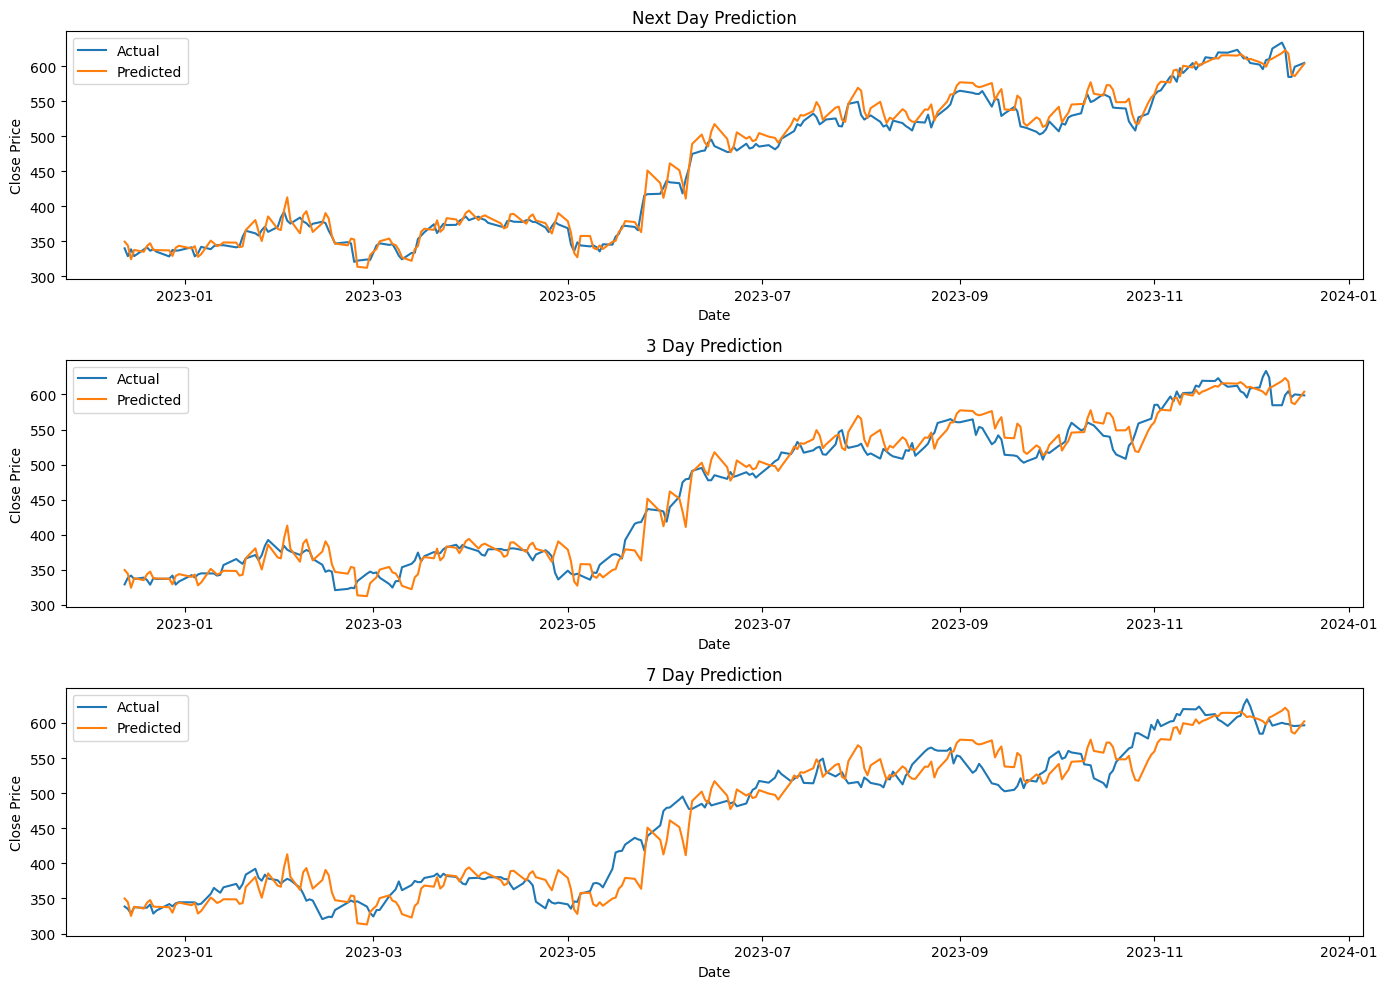

In [5]:
# Make predictions
predictions = model.predict([x50, x200, xvol, xticker])

# Extract predictions for each time horizon
next_day_pred = predictions[:, 0]
three_days_pred = predictions[:, 1]
next_week_pred = predictions[:, 2]

# Extract actual values for each time horizon
next_day_actual = yvals[:, 0]
three_days_actual = yvals[:, 1]
next_week_actual = yvals[:, 2]

# Plot the results
plt.figure(figsize=(14, 10))

# Next day predictions
plt.subplot(3, 1, 1)
plt.plot(dates, next_day_actual, label='Actual')
plt.plot(dates, next_day_pred, label='Predicted')
plt.title('Next Day Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# Three day predictions
plt.subplot(3, 1, 2)
plt.plot(dates, three_days_actual, label='Actual')
plt.plot(dates, three_days_pred, label='Predicted')
plt.title('3 Day Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# Next week predictions
plt.subplot(3, 1, 3)
plt.plot(dates, next_week_actual, label='Actual')
plt.plot(dates, next_week_pred, label='Predicted')
plt.title('7 Day Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:

def runsim(model, TICKER, TICKERS_ONEHOT, TOP_25_STOCKS):
    # Load the data
    data = yf.download(TICKER, start="2022-03-01", end="2024-01-01", progress=False)
    data = data.drop(columns=['Open', 'High', 'Low', 'Adj Close'])
    data.insert(0, 'Ticker', TICKER, True)

    data['Date'] = data.index
    data['index'] = range(len(data))
    data.set_index('index', inplace=True)

    # Preprocess the data
    dates = []
    x50 = []
    x200 = []
    xvol = []
    xticker = []

    for i in range(50*4, len(data) - 7):
        dates.append(data['Date'].values[i-1])
        x50.append(data['Close'].values[i-50:i])
        x200.append(data['Close'].values[i-200:i])
        xvol.append(data['Volume'].values[i-50:i])
        ticker = TICKERS_ONEHOT[TOP_25_STOCKS.index(TICKER)]
        xticker.append(ticker)

    x50 = np.array(x50)
    x200 = np.array(x200)
    xvol = np.array(xvol)
    xticker = np.array(xticker)


    # Make predictions
    predictions = model.predict([x50, x200, xvol, xticker])

    # Extract predictions for next day
    next_day_pred = predictions[:, 0]

    # Extract actual close prices
    actual_close = data['Close'].values[50*4:]

    # Initialize variables for simulation
    initial_capital = 1000
    cash = initial_capital
    position = 0  # Number of shares held
    portfolio_value = []

    for i in range(len(next_day_pred)):
        current_price = actual_close[i]
        predicted_next_price = next_day_pred[i]
        
        # Buy if the predicted next day price is higher than the current price
        if predicted_next_price > current_price:
            if cash > 0:  # Buy only if we have cash
                position = cash / current_price  # Buy as many shares as we can
                cash = 0
        # Sell if the predicted next day price is lower than the current price
        elif predicted_next_price < current_price:
            if position > 0:  # Sell only if we have shares
                cash = position * current_price  # Sell all shares
                position = 0
        
        # Calculate portfolio value
        portfolio_value.append(cash + position * current_price)

    # Calculate final portfolio value
    final_portfolio_value = cash + position * actual_close[-1]

    # Calculate ROI
    roi = (final_portfolio_value - initial_capital) / initial_capital * 100
    print(dates[0], dates[-1])
    return portfolio_value, final_portfolio_value, roi

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2022-12-13T00:00:00.000000000 2023-12-18T00:00:00.000000000
Final Portfolio Value: $1466.08
Return on Investment: 46.61%


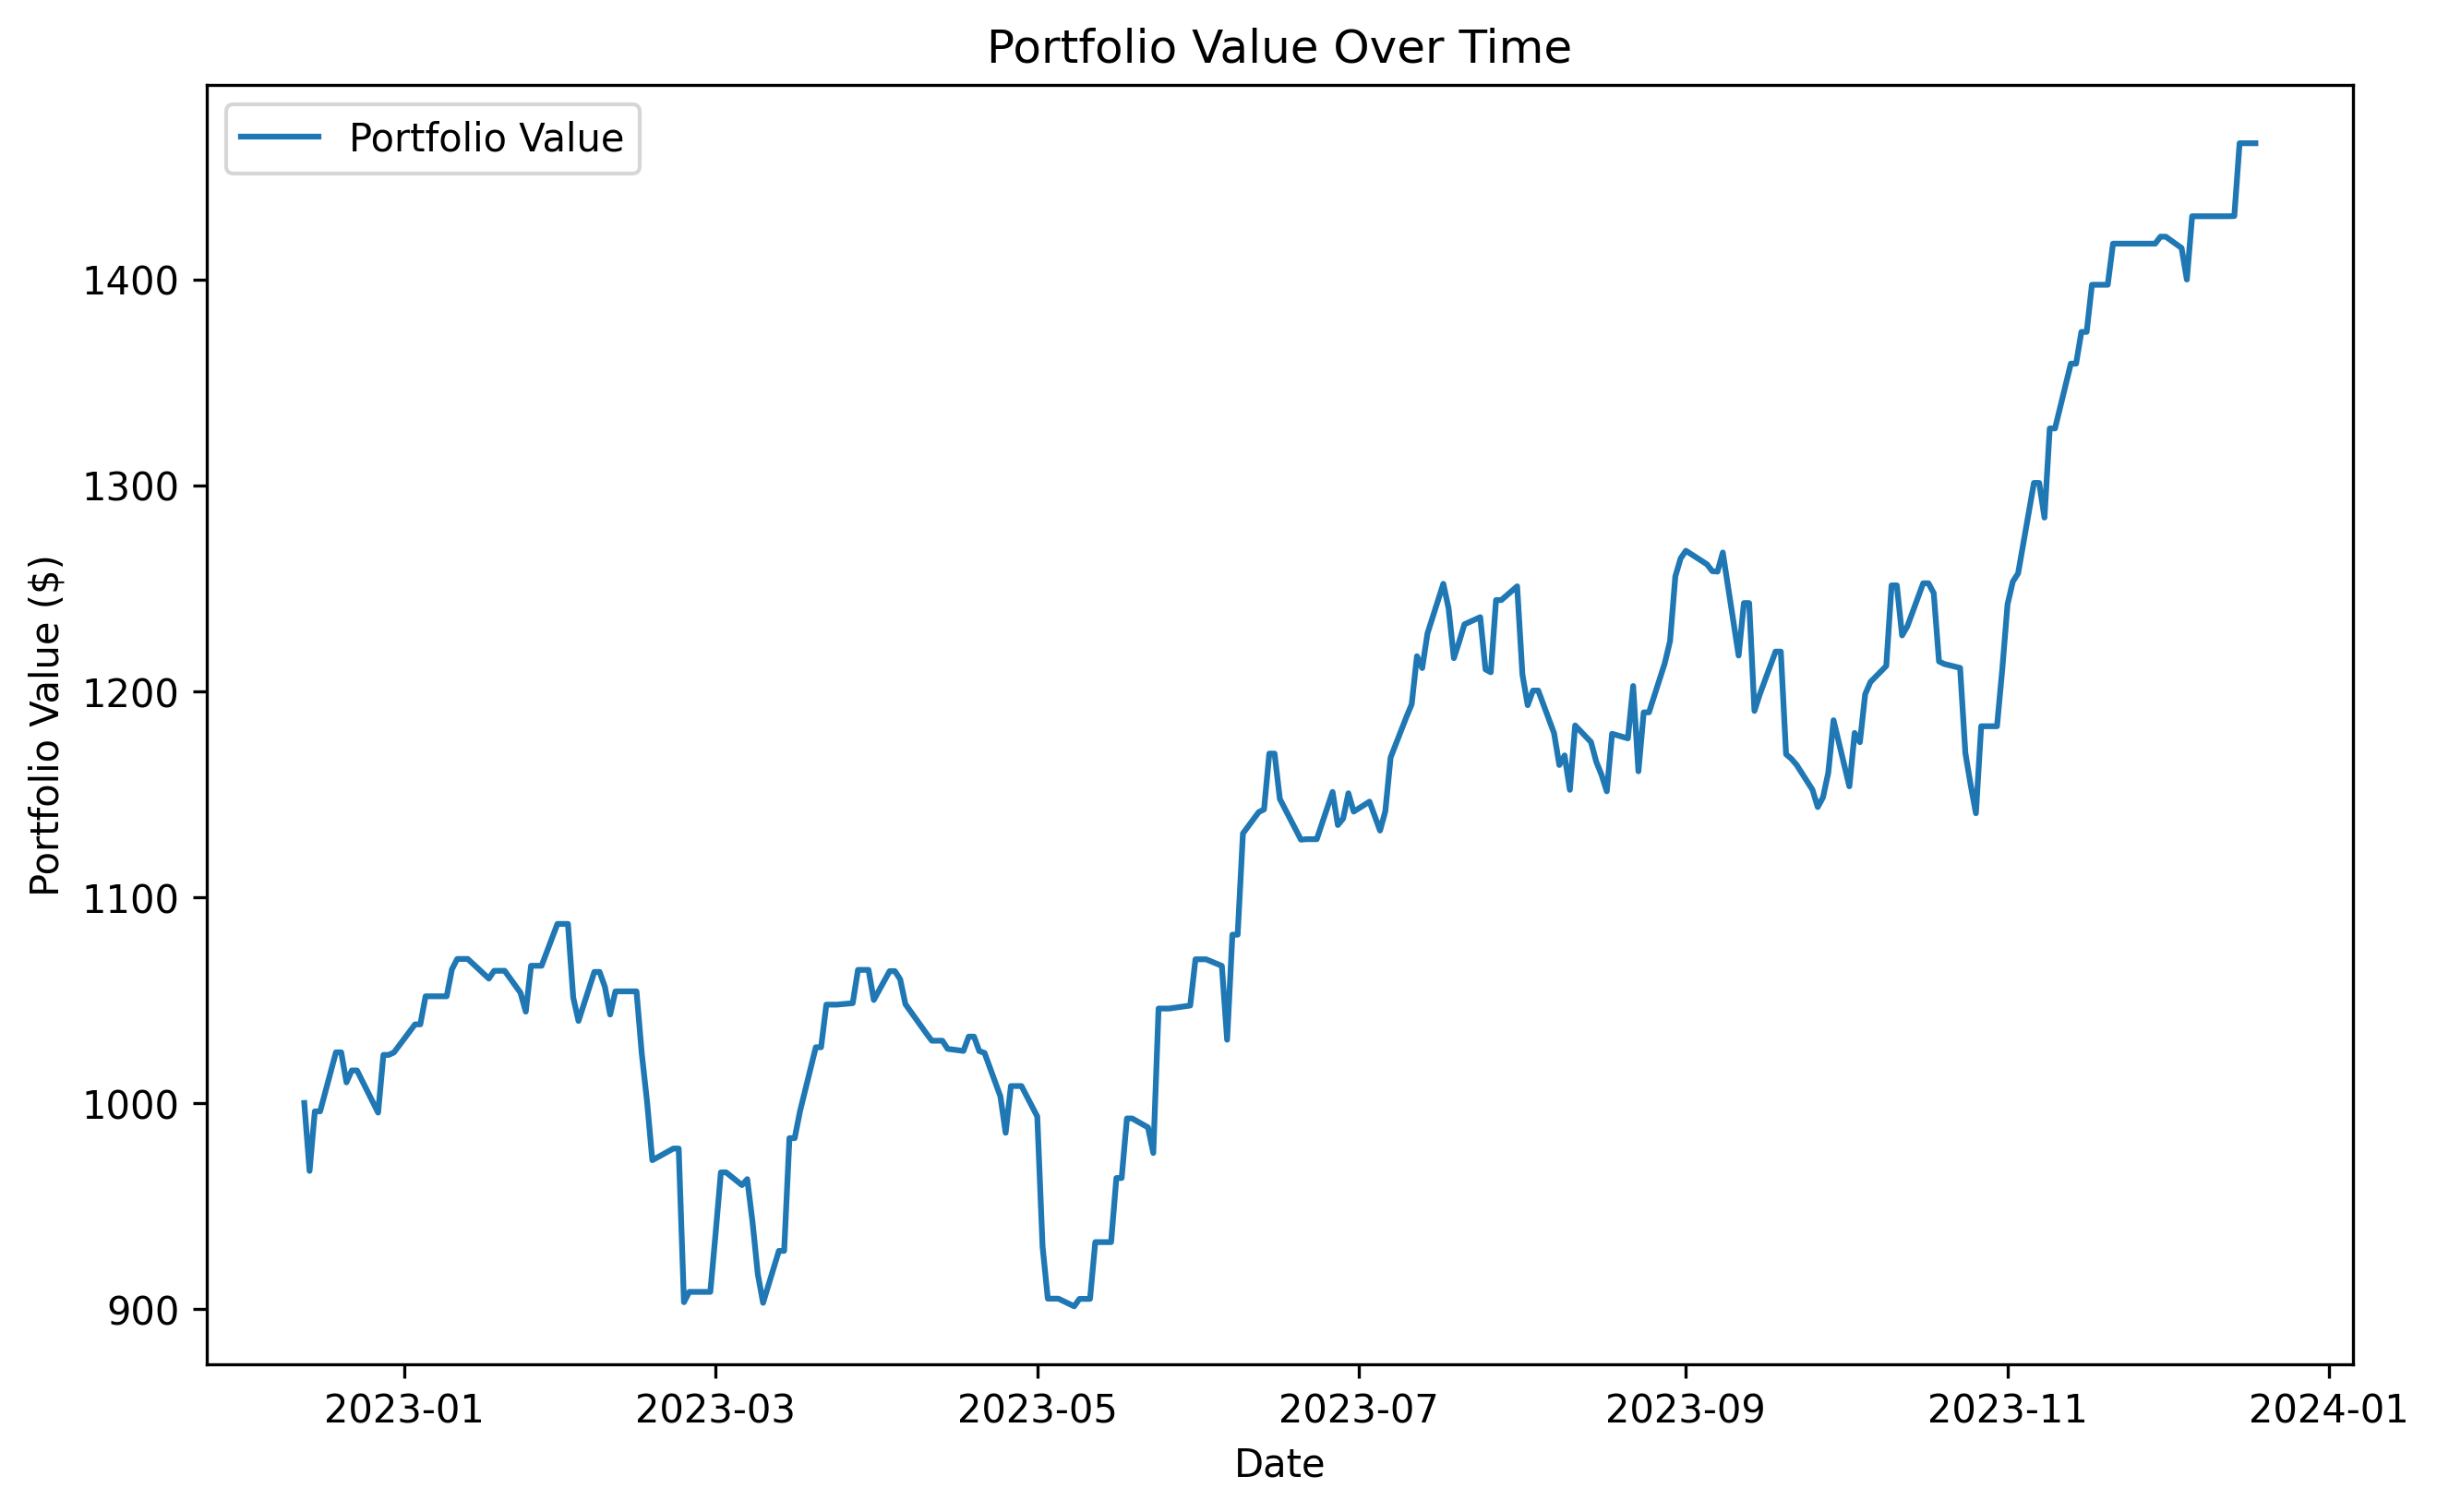

In [26]:

portfolio_value, final_portfolio_value, roi = runsim(model, TICKER, TICKERS_ONEHOT, TOP_25_STOCKS)

print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
print(f"Return on Investment: {roi:.2f}%")

# Plot portfolio value over time
plt.figure(figsize=(10, 6))
plt.plot(dates, portfolio_value, label='Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2022-12-13T00:00:00.000000000 2023-12-18T00:00:00.000000000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2022-12-13T00:00:00.000000000 2023-12-18T00:00:00.000000000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2022-12-13T00:00:00.000000000 2023-12-18T00:00:00.000000000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2022-12-13T00:00:00.000000000 2023-12-18T00:00:00.000000000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2022-12-13T00:00:00.000000000 2023-12-18T00:00:00.000000000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2022-12-13T00:00:00.000000000 2023-12-18T00:00:00.000000000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2022-12-13T00:00:00.000000000 2023-12-18T00:00:00.000000000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2022-12-13T00:00:00.000000000 2023-12-18T00:00:00.000000000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2022-12-13T00:00:00.000000000 2023-12-18T00:00:00.000000000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2022-12-13T00:00:00.000000000 2023-12-18T00:00:00.000000000
8/8 ━━━━━━━━━━━━━━━━

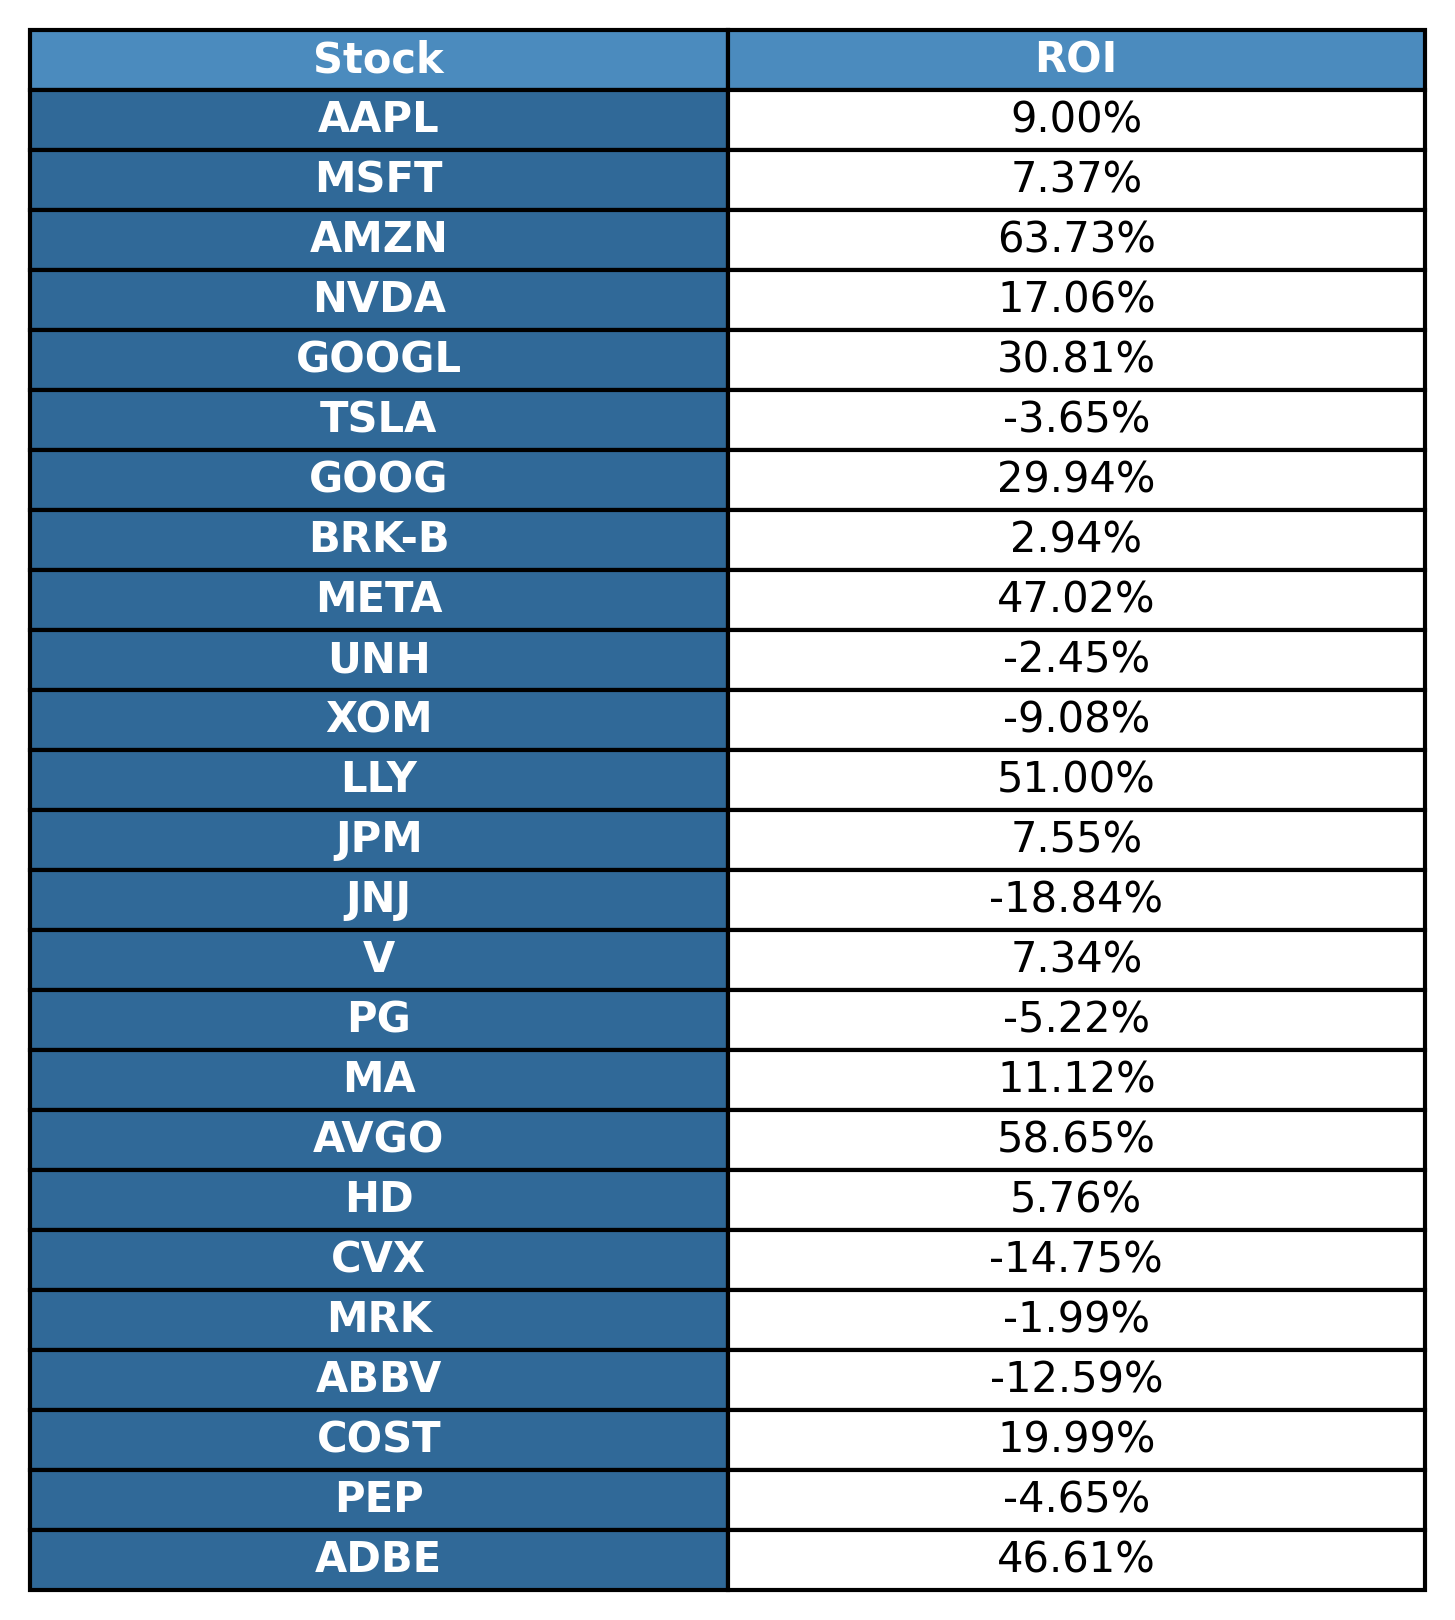

In [27]:
roi_results = {}

# Run simulation for each stock
for stock in TOP_25_STOCKS:
    _, final_portfolio_value, roi = runsim(model, stock, TICKERS_ONEHOT, TOP_25_STOCKS)
    roi_results[stock] = f'{roi:.2f}%'

# Create DataFrame to store the results
roi_df = pd.DataFrame(list(roi_results.items()), columns=['Stock', 'ROI'])

# Plot the table
fig, ax = plt.subplots(figsize=(5, 5))  # Set size frame
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=roi_df.values, colLabels=roi_df.columns, cellLoc='center', loc='center')

table.auto_set_font_size(True)
#table.set_fontsize(12)
table.scale(1.2, 1.2)  # Adjust the scale for readability

# Change colors for the header and first column
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_text_props(fontweight='bold', color='white')
        cell.set_facecolor('#4B8BBE')  # Python blue for the header
    elif j == 0:
        cell.set_text_props(fontweight='bold', color='white')
        cell.set_facecolor('#306998')  # Python blue for the ticker names

# Display the table
plt.show()
